Decay rate inside nanosphere
====================================

*Mie decay rate provided by G. Colas des Francs & Y. Brûlé*

In this example, we demonstrate how the decay rate of an electric as well as a magnetic dipolar emitter is influenced if it is placed at the inside of a dielectric nanosphere and we compare the results to Mie theory.
 

Simulation setup
--------------------

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 907/907 dipoles valid


/home/pwiecha/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


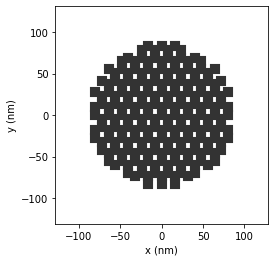

N dp 907


In [1]:
from pyGDM2 import core
from pyGDM2 import fields
from pyGDM2 import structures
from pyGDM2 import propagators
from pyGDM2 import materials
from pyGDM2 import tools
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt


## --- simulation config
step = 16
geo = structures.sphere(step, R=82/step, mesh='hex')  #82nm GDM vs 80nm Mie: manual tuning to account for small shift with respect to Mie
mat = materials.dummy(3.5)
struct = structures.struct_py(step, geo, mat)

## incident field
wavelengths = np.linspace(550, 650, 20)
field_generator = fields.plane_wave   # dummy config (will be ignored for LDOS)
kwargs = dict()                       # dummy config (will be ignored for LDOS)
efield = fields.efield(fields.dipole_electric, wavelengths=wavelengths, kwargs=kwargs)

## environment
dyads = propagators.DyadsQuasistatic123(n1=1)

## sim. class
sim = core.simulation(struct, efield, dyads)

visu.structure(sim)
print('N dp', len(sim.struct.geometry))

Decay rate simulation
----------------------------------------------

Rasterscanning a 2D grid, we now we run the decay rate simulation for an electric as well as for a magnetic dipole transition (see [1] for details on the formalism).

**Note** that the first run of the respective LDOS calculation (E / H) can be slow because numba JIT-compiles the accelerated module from the python code. 

In [2]:
r_probe = geo   # all mesh-positions --> LDOS distribution inside sphere

## ----- LDOS spectra
wl, E_decay_spec = tools.calculate_spectrum(sim, 0, core.decay_rate, 
                                            r_probe=r_probe, component='e')
wl, H_decay_spec = tools.calculate_spectrum(sim, 0, core.decay_rate, 
                                            r_probe=r_probe, component='h')

## average of full sphere 
g_GDM_E = np.mean(E_decay_spec[...,3], axis=(1,2))
g_GDM_H = np.mean(H_decay_spec[...,3], axis=(1,2))


## ----- calculate LDOS at peak wavelength, along profile through sphere center
wavelength_peak = wl[np.argmax(np.mean(E_decay_spec[...,3], axis=(1,2))*10)]
N_probe = 100
r_probe = np.array([np.linspace(0, 160, N_probe), np.zeros(N_probe), 
                    sim.struct.geometry.T[2].mean() * np.ones(N_probe)]).T
r_probe.T[0] += sim.struct.geometry.T[0].mean()

gamma_profiles_E = core.decay_rate(sim, wavelength=wavelength_peak, 
                                   r_probe=r_probe, component='E', 
                                   return_value='decay_rates')

gamma_profiles_M = core.decay_rate(sim, wavelength=wavelength_peak, 
                                   r_probe=r_probe, component='H', 
                                   return_value='decay_rates')

pr_GDM_E_per = gamma_profiles_E[0].T[3]
pr_GDM_E_par = gamma_profiles_E[1].T[3]
pr_GDM_H_per = gamma_profiles_M[0].T[3]
pr_GDM_H_par = gamma_profiles_M[1].T[3]

/home/pwiecha/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


E-LDOS at wl=550.0nm - K: 3.2s, source-zone (907/907 pos): 0.1s, Done in 3.3s
E-LDOS at wl=555.3nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.6s
E-LDOS at wl=560.5nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.5s
E-LDOS at wl=565.8nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.5s
E-LDOS at wl=571.1nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.6s
E-LDOS at wl=576.3nm - K: 2.4s, source-zone (907/907 pos): 0.1s, Done in 2.5s
E-LDOS at wl=581.6nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.5s
E-LDOS at wl=586.8nm - K: 2.4s, source-zone (907/907 pos): 0.1s, Done in 2.4s
E-LDOS at wl=592.1nm - K: 2.8s, source-zone (907/907 pos): 0.1s, Done in 2.9s
E-LDOS at wl=597.4nm - K: 2.6s, source-zone (907/907 pos): 0.1s, Done in 2.7s
E-LDOS at wl=602.6nm - K: 2.6s, source-zone (907/907 pos): 0.1s, Done in 2.6s
E-LDOS at wl=607.9nm - K: 2.5s, source-zone (907/907 pos): 0.1s, Done in 2.6s
E-LDOS at wl=613.2nm - K: 2.7s, source-zone (907/907 pos): 0.1s,

plot the results for different orientations
------------------------------------------------------

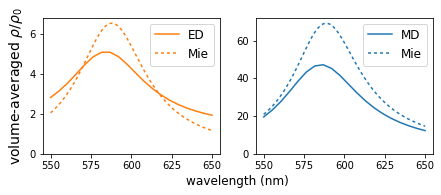

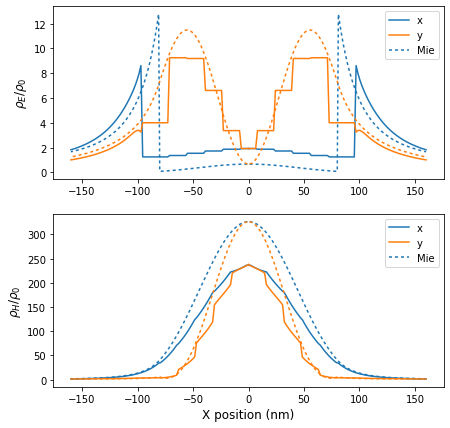

In [3]:
## --- load Mie values for comparison
wl_Mie, g_Mie_E, g_Mie_H = np.loadtxt("decayrate_avg_mie_n35_r80_inside.txt").T
r_probe_mie, pr_Mie_H_per, pr_Mie_H_par = np.loadtxt("decayrate_gammaH_mie_n35_r80_profile.txt").T
r_probe_mie, pr_Mie_E_per, pr_Mie_E_par = np.loadtxt("decayrate_gammaE_mie_n35_r80_profile.txt").T



## --- plot the LDOS spectra
plt.figure(figsize=(7,2.5))
plt.subplot(121)
plt.plot(wl, g_GDM_E, label=r'ED', color='C1')
plt.plot(wl_Mie, g_Mie_E, label=r'Mie', dashes=[2,2], color='C1')
plt.ylim(0, plt.ylim()[1])

plt.ylabel(r'volume-averaged $\rho / \rho_0$', fontsize=14)
plt.legend(fontsize=12)


plt.subplot(122)
plt.plot(wl, g_GDM_H, label='MD', color='C0')
plt.plot(wl_Mie, g_Mie_H, label='Mie', dashes=[2,2], color='C0')
plt.ylim(0, plt.ylim()[1])

plt.xlabel('wavelength (nm)', fontsize=12, x=-0.1)
plt.legend(fontsize=12)

plt.show()



## --- plot the profiles
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.plot(r_probe.T[0], pr_GDM_E_per, label='x', color='C0')
plt.plot(-r_probe.T[0], pr_GDM_E_per, label='', color='C0') # symmetry 

plt.plot(r_probe.T[0], pr_GDM_E_par, label='y', color='C1')
plt.plot(-r_probe.T[0], pr_GDM_E_par, label='', color='C1') # symmetry 

plt.plot(r_probe_mie, pr_Mie_E_per, label='Mie', color='C0', dashes=[2,2])
plt.plot(-r_probe_mie, pr_Mie_E_per, label='', color='C0', dashes=[2,2]) # symmetry 

plt.plot(r_probe_mie, pr_Mie_E_par, label='', color='C1', dashes=[2,2])
plt.plot(-r_probe_mie, pr_Mie_E_par, label='', color='C1', dashes=[2,2]) # symmetry 

plt.ylabel(r'$\rho_E / \rho_0$', fontsize=12)
plt.legend()


plt.subplot(212)
plt.plot(r_probe.T[0], pr_GDM_H_per, label='x', color='C0')
plt.plot(-r_probe.T[0], pr_GDM_H_per, color='C0') # symmetry 

plt.plot(r_probe.T[0], pr_GDM_H_par, label='y', color='C1')
plt.plot(-r_probe.T[0], pr_GDM_H_par, label='', color='C1') # symmetry 

plt.plot(r_probe_mie, pr_Mie_H_per, label='Mie', color='C0', dashes=[2,2])
plt.plot(-r_probe_mie, pr_Mie_H_per, label='', color='C0', dashes=[2,2]) # symmetry 
plt.plot(r_probe_mie, pr_Mie_H_par, label='', color='C1', dashes=[2,2])
plt.plot(-r_probe_mie, pr_Mie_H_par, label='', color='C1', dashes=[2,2]) # symmetry 

plt.xlabel(r'X position (nm)', fontsize=12)
plt.ylabel(r'$\rho_H / \rho_0$', fontsize=12)
plt.legend()


plt.show()